# Exploratory Data Analysis (EDA) on Amazon Dataset

This is the EDA notebook for the **Amazon Clothing, Shoes & Jewelry** datasets. This notebook explores two key datasets to understand product characteristics and customer feedback.

---

## 1. Datasets Overview

We are working with the following two datasets:

 - Reviews Dataset
 - Metadata Dataset

 This is a subset of [Amazon Reviews 2023](https://amazon-reviews-2023.github.io/)

 - Both these datasets are limited to the subsection of **Amazon Clothing, Shoes & Jewelry**

### 1.1. Reviews DataFrame
Customer-generated content, including:
- Review Text
- Star Ratings
- Review Date
- Reviewer ID & Name

### 1.2 Meta DataFrame
Product-level information, such as:
- Product Title
- Brand
- Categories
- Price
- Image URLs

### 1.3 Key Column: `asin`
The `asin` column (Amazon Standard Identification Number) links the two datasets:
- **Primary key** in the Meta DataFrame
- **Foreign key** in the Reviews DataFrame

---

## 2. Goals of EDA

- Understand the **distribution** of reviews and ratings
- Analyze **review trends** over time
- Explore the **popularity** of different brands/categories
- Detect missing or inconsistent data
- Prepare the datasets for downstream tasks like recommendation, sentiment analysis, or predictive modeling

---

## 3. EDA Roadmap

1. **Data Preview & Cleaning**
2. **Missing Values & Data Types**
3. **Merging Reviews with Meta Data**
4. **Univariate Analysis** (ratings, categories, prices, etc.)
5. **Bivariate/Multivariate Analysis**
6. **Insights & Observations**

---

## 4. Project Goal
The objective of this project is to extract actionable insights from customer reviews in the *Clothing, Shoes and Jewelry* category of the [Amazon Reviews 2023 dataset](https://cseweb.ucsd.edu/~jmcauley/datasets/amazon_v2.0/) to support data-driven business decisions. By analyzing review content and patterns, we aim to help businesses improve customer satisfaction, optimize product offerings, and enhance the overall shopping experience.

**Key Analyses Planned:**  
- **Sentiment Analysis:** Understand customer satisfaction by classifying reviews as positive, neutral, or negative.  
- **Topic Modeling:** Identify common themes and recurring issues discussed in reviews to inform product development and customer service strategies.  
- **Review Helpfulness Prediction:** Predict which reviews are likely to be marked as helpful, helping surface valuable feedback to future shoppers.  
- **Time Series and Sentiment Analysis:** Detect trends in review volume and sentiment over time, revealing seasonal or time-based patterns in customer behavior.

---

## Data Merging Pipeline: Integration of Reviews and Metadata Tables:



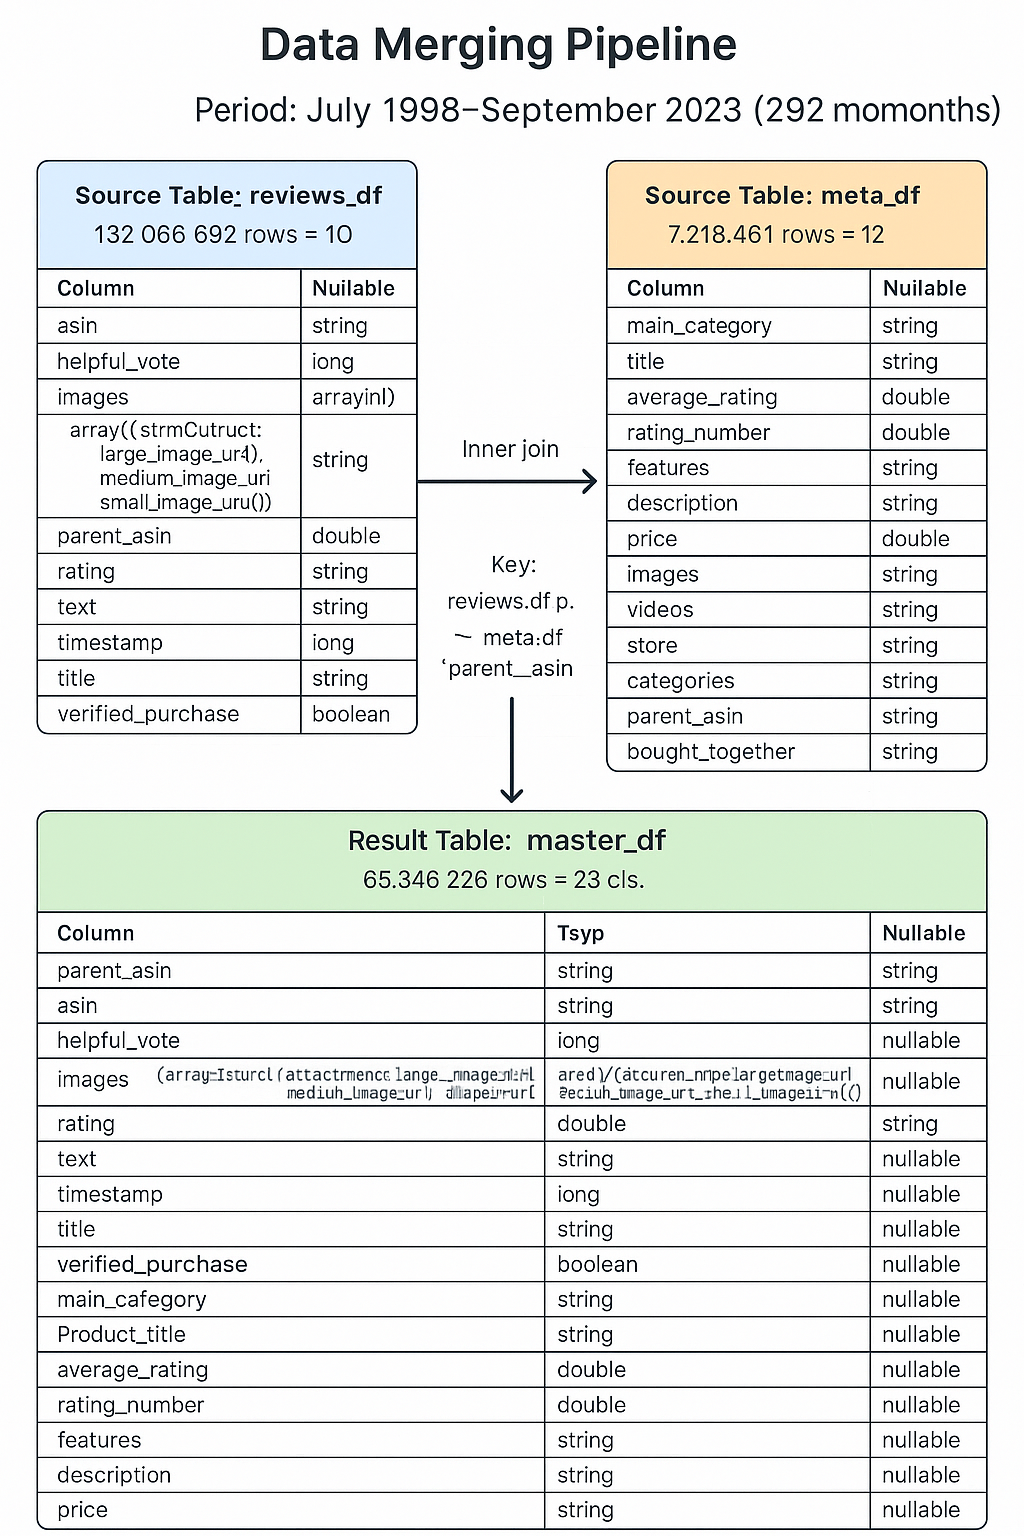

In [ ]:
# ------------------------------------------------------------------------------------------------------------
# This cell contains all the libraries and modules that need to be accessed throughout the course of this EDA.
# ------------------------------------------------------------------------------------------------------------
from pyspark.sql.types import StructType, StructField, StringType, ArrayType, IntegerType, FloatType, DoubleType, MapType
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, sum as _sum, year, from_unixtime, col, length
from pyspark.sql.functions import from_json, col, schema_of_json
from pyspark.sql.functions import count, desc, DataFrame
from pyspark.sql import Row
from pyspark.sql.types import StructType, StructField
from matplotlib.ticker import FuncFormatter
import tqdm


import pandas as pd
import json

from wordcloud import WordCloud
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import nltk
import re

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [ ]:
# ------------------------------------------------------------------------------------------------------
# CONFIGS : This cell contains all the configuration variables that needs to be accessed and are common.
# ------------------------------------------------------------------------------------------------------


reviews_path = "gs://ba843-group1-project/Clothing_Shoes_and_Jewelry.jsonl.gz"
reviews_output_path = "gs://ba843-group1-project/Clothing_Shoes_and_Jewelry_converted.parquet"
meta_path = "gs://ba843-group1-project/meta_Clothing_Shoes_and_Jewelry.jsonl.gz"
meta_output_path  = "gs://ba843-group1-project/meta_Clothing_Shoes_and_Jewelry_converted_shubham.parquet"
merged_output_path = "gs://ba843-group1-project/merged_review_dedup_data.parquet"
common_key = "parent_asin"
master_data_path = "gs://ba843-group1-project/master_data.parquet"
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

In [ ]:
# --------------------------------------------------------------------------------
# UTILS: This cell contains all the utility functions that will be called for EDA.
# --------------------------------------------------------------------------------


def preprocess(text):

    """
    Preprocesses the input text by performing the following steps:
    1. Converts the text to lowercase.
    2. Removes URLs and non-alphabetic characters.
    3. Splits the text into words.
    4. Removes stop words and words with length less than or equal to 2.
    5. Lemmatizes the remaining words.

    Parameters:
        text (str): The input text to preprocess.

    Returns:
        str: The cleaned and preprocessed text.
    """

    if not isinstance(text, str):
        return ""
    text = text.lower()
    text = re.sub(r"http\S+|[^a-z\s]", "", text)  # Remove URLs & non-letters
    words = text.split()
    words = [lemmatizer.lemmatize(word) for word in words if word not in stop_words and len(word) > 2]
    return " ".join(words)


def count_nulls(df):

    '''
    Function to count nulls for each column in a DataFrame

    Parameters :
    - df (dataframe)   : Pyspark Dataframe

    Returns:
    - py_df (dataframe) : Pyspark Dataframe containing number of null values

    '''


    py_df = df.select([_sum(col(c).isNull().cast("int")).alias(c) for c in df.columns]).show()
    return py_df

def null_percent(df):

    '''
    Function to return %ge of nulls for each column in a DataFrame

    Input :
    - df    : Pyspark Dataframe

    Output:
    - py_df : Pyspark Dataframe containing %ge of null values
    '''


    total = df.count()
    return df.select([
        (_sum(col(c).isNull().cast("int")) / total).alias(c) for c in df.columns
    ])


def drop_duplicate_columns_rebuild(df):

    """
    Removes duplicate columns from a Spark DataFrame by rebuilding it
    using only the first occurrence of each column name.

    This function:
    1. Identifies and keeps the first occurrence of each unique column name.
    2. Creates a new schema with only the unique columns.
    3. Reconstructs the DataFrame using the cleaned schema and data.

    Parameters:
        df (pyspark.sql.DataFrame): The input Spark DataFrame possibly containing duplicate columns.

    Returns:
        pyspark.sql.DataFrame: A new DataFrame with duplicate columns removed.
    """

    fields = df.schema.fields
    seen = set()
    unique_indices = []
    unique_names = []

    for idx, field in enumerate(fields):
        name = field.name
        if name not in seen:
            seen.add(name)
            unique_indices.append(idx)
            unique_names.append(name)

    # Create a schema from the unique fields
    unique_fields = [fields[i] for i in unique_indices]
    schema = StructType(unique_fields)

    # Create new RDD of Row objects
    new_rdd = df.rdd.map(lambda row: Row(*[row[i] for i in unique_indices]))

    # Rebuild the DataFrame
    deduped_df = spark.createDataFrame(new_rdd, schema=schema)

    return deduped_df

In [ ]:
#Creating the spark session
spark = SparkSession.builder.appName("AmazonReviews").getOrCreate()

Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
25/04/28 23:08:19 INFO SparkEnv: Registering MapOutputTracker
25/04/28 23:08:19 INFO SparkEnv: Registering BlockManagerMaster
25/04/28 23:08:19 INFO SparkEnv: Registering BlockManagerMasterHeartbeat
25/04/28 23:08:20 INFO SparkEnv: Registering OutputCommitCoordinator


------

#### 1. Reading the datasets.

In [ ]:
# This dataset contains the raw text from the reviews parquet file
review_df = spark.read.parquet(reviews_output_path)

In [ ]:
#Checking the first 5 records
print("Reviews:")
review_df.show(5, truncate=True)

Reviews:


+----------+------------+--------------------+-----------+------+--------------------+-------------+--------------------+--------------------+-----------------+
|      asin|helpful_vote|              images|parent_asin|rating|                text|    timestamp|               title|             user_id|verified_purchase|
+----------+------------+--------------------+-----------+------+--------------------+-------------+--------------------+--------------------+-----------------+
|B096S6LZV4|           0|[{IMAGE, https://...| B09NSZ5QMF|   3.0|Unfortunately Ama...|1677938767351|Arrived Damaged :...|AFKZENTNBQ7A7V7UX...|             true|
|B09KMDBDCN|           0|                  []| B08NGL3X17|   3.0|Useless under 40 ...|1677083819242|Useless under 40 ...|AFKZENTNBQ7A7V7UX...|            false|
|B096N5WK8Q|          11|                  []| B07RGM3DYC|   4.0|I purchased these...|1675524098918|Not waterproof, b...|AFKZENTNBQ7A7V7UX...|             true|
|B07JR4QBZ4|          26|[{IMAGE, 

In [ ]:
#Checking the number of records
num_rows = review_df.count()
num_cols = len(review_df.columns)

print(f"Number of rows: {num_rows}")
print(f"Number of columns: {num_cols}")

Number of rows: 132066692
Number of columns: 10


In [ ]:
review_df.cache()

DataFrame[asin: string, helpful_vote: bigint, images: array<struct<attachment_type:string,large_image_url:string,medium_image_url:string,small_image_url:string>>, parent_asin: string, rating: double, text: string, timestamp: bigint, title: string, user_id: string, verified_purchase: boolean]

In [ ]:
#This dataset contains the metadata for the products that have been reviewed

# ------------------------------------------------------------------------------------------------------------------------------------------------------------
# NOTE : The original file was having a nested JSON and SPARK was crashing. We created the parquet for that locally using custom Schema andd doing in batches
# ------------------------------------------------------------------------------------------------------------------------------------------------------------

meta_df = spark.read.parquet(meta_output_path)

In [ ]:
#Checking the first 5 records
print("Metadata:")
meta_df.show(5, truncate=True)

Metadata:


+--------------+--------------------+--------------+-------------+--------------------+--------------------+------+--------------------+--------------------+------------+--------------------+-----------+---------------+
| main_category|               title|average_rating|rating_number|            features|         description| price|              images|              videos|       store|          categories|parent_asin|bought_together|
+--------------+--------------------+--------------+-------------+--------------------+--------------------+------+--------------------+--------------------+------------+--------------------+-----------+---------------+
|AMAZON FASHION|BALEAF Women's Lo...|           4.2|        422.0|['90% Polyester, ...|                  []| 31.99|[{'thumb': 'https...|[{'title': "Women...|      BALEAF|['Clothing, Shoes...| B09X1MRDN6|           NULL|
|AMAZON FASHION|Merrell Work Moab...|           2.7|          4.0|     ['Rubber sole']|                  []|  NULL|[{'th

In [ ]:
meta_df.cache()

DataFrame[main_category: string, title: string, average_rating: double, rating_number: double, features: string, description: string, price: double, images: string, videos: string, store: string, categories: string, parent_asin: string, bought_together: string]

In [ ]:
#Checking the number of records

num_rows = meta_df.count()
num_cols = len(meta_df.columns)

print(f"Number of rows: {num_rows}")
print(f"Number of columns: {num_cols}")

Number of rows: 7218481
Number of columns: 13


In [ ]:
# Write merged_df to Google Cloud Storage as a Parquet file
merged_df.write \
    .mode("overwrite") \      # or "append", "errorifexists", etc.
    .parquet("gs://ba843-group1-project/master_data.parquet")

----

#### 2. Checking missing values and data types.

In [ ]:
print("Review Data Types:")
review_df.printSchema()

print("Metadata Data Types:")
meta_df.printSchema()

Review Data Types:
root
 |-- asin: string (nullable = true)
 |-- helpful_vote: long (nullable = true)
 |-- images: array (nullable = true)
 |    |-- element: struct (containsNull = true)
 |    |    |-- attachment_type: string (nullable = true)
 |    |    |-- large_image_url: string (nullable = true)
 |    |    |-- medium_image_url: string (nullable = true)
 |    |    |-- small_image_url: string (nullable = true)
 |-- parent_asin: string (nullable = true)
 |-- rating: double (nullable = true)
 |-- text: string (nullable = true)
 |-- timestamp: long (nullable = true)
 |-- title: string (nullable = true)
 |-- user_id: string (nullable = true)
 |-- verified_purchase: boolean (nullable = true)

Metadata Data Types:
root
 |-- main_category: string (nullable = true)
 |-- title: string (nullable = true)
 |-- average_rating: double (nullable = true)
 |-- rating_number: double (nullable = true)
 |-- features: string (nullable = true)
 |-- description: string (nullable = true)
 |-- price: double 

In [ ]:
print("Null Counts in Metadata")
count_nulls(meta_df)
# Main Category, price, store and bought together are having missing value. Let's analyze the percentage of missing values in the column.

Null Counts in Metadata


+-------------+-----+--------------+-------------+--------+-----------+-------+------+------+-----+----------+-----------+---------------+
|main_category|title|average_rating|rating_number|features|description|  price|images|videos|store|categories|parent_asin|bought_together|
+-------------+-----+--------------+-------------+--------+-----------+-------+------+------+-----+----------+-----------+---------------+
|       929740|    0|             0|            0|       0|          0|5759247|     0|     0|45486|         0|          0|        7218481|
+-------------+-----+--------------+-------------+--------+-----------+-------+------+------+-----+----------+-----------+---------------+



In [ ]:
print("Null Percentage in Metadata")
null_percent(meta_df).show()

Null Percentage in Metadata


+-------------------+-----+--------------+-------------+--------+-----------+-----------------+------+------+--------------------+----------+-----------+---------------+
|      main_category|title|average_rating|rating_number|features|description|            price|images|videos|               store|categories|parent_asin|bought_together|
+-------------------+-----+--------------+-------------+--------+-----------+-----------------+------+------+--------------------+----------+-----------+---------------+
|0.12879995112545145|  0.0|           0.0|          0.0|     0.0|        0.0|0.797847497278167|   0.0|   0.0|0.006301325722129074|       0.0|        0.0|            1.0|
+-------------------+-----+--------------+-------------+--------+-----------+-----------------+------+------+--------------------+----------+-----------+---------------+



In [ ]:
print("Null Counts in Reviews data")
count_nulls(review_df)

# This has all the data, and there are no missing values for reviews.

Null Counts in Reviews data


+----+------------+------+-----------+------+----+---------+-----+-------+-----------------+
|asin|helpful_vote|images|parent_asin|rating|text|timestamp|title|user_id|verified_purchase|
+----+------------+------+-----------+------+----+---------+-----+-------+-----------------+
|   0|           0|     0|          0|     0|   0|        0|    0|      0|                0|
+----+------------+------+-----------+------+----+---------+-----+-------+-----------------+



In [ ]:
print("Null Percentage in Reviews data:")
null_percent(review_df).show()

Null Percentage in Reviews data:


+----+------------+------+-----------+------+----+---------+-----+-------+-----------------+
|asin|helpful_vote|images|parent_asin|rating|text|timestamp|title|user_id|verified_purchase|
+----+------------+------+-----------+------+----+---------+-----+-------+-----------------+
| 0.0|         0.0|   0.0|        0.0|   0.0| 0.0|      0.0|  0.0|    0.0|              0.0|
+----+------------+------+-----------+------+----+---------+-----+-------+-----------------+



In [ ]:
meta_df = meta_df.withColumnRenamed("title", "Product_title")

In [ ]:
# Merging the datasets together to get a unified dataset that has the product description tagged to the review

merged_df = review_df.join(meta_df, on=[common_key], how="inner")
print ("Top 5 rows of merged data:\n")
merged_df.show(5, truncate=True)

Top 5 rows of merged data:



+-----------+----------+------------+------+------+--------------------+-------------+--------------------+--------------------+-----------------+-----------------+--------------------+--------------+-------------+--------------------+--------------------+-----+--------------------+------+------------------------------------+--------------------+---------------+
|parent_asin|      asin|helpful_vote|images|rating|                text|    timestamp|               title|             user_id|verified_purchase|    main_category|       Product_title|average_rating|rating_number|            features|         description|price|              images|videos|                               store|          categories|bought_together|
+-----------+----------+------------+------+------+--------------------+-------------+--------------------+--------------------+-----------------+-----------------+--------------------+--------------+-------------+--------------------+--------------------+-----+--------

In [ ]:
#Checking the total number of records in the dataset when merged

num_rows = merged_df.count()
num_cols = len(merged_df.columns)

print(f"Number of rows: {num_rows}")
print(f"Number of columns: {num_cols}")

Number of rows: 132066692
Number of columns: 22


In [ ]:
merged_df.cache()

DataFrame[parent_asin: string, asin: string, helpful_vote: bigint, images: array<struct<attachment_type:string,large_image_url:string,medium_image_url:string,small_image_url:string>>, rating: double, text: string, timestamp: bigint, title: string, user_id: string, verified_purchase: boolean, main_category: string, title: string, average_rating: double, rating_number: double, features: string, description: string, price: double, images: string, videos: string, store: string, categories: string, bought_together: string]

## 1. EDA

#### 1.1 Creating the non duplicated records and saving it.

In [ ]:
#Checking duplicates (Logic: Same user_id at the same product asin cannot have same multiple comments at the same timestamp)

duplicate_comments_pivot = merged_df.groupBy(["user_id", "asin", "timestamp"]) \
         .agg(count("*").alias("count_duplicated")) \
         .filter("count_duplicated > 1") \
         .orderBy(desc("count_duplicated"))

In [ ]:
duplicate_comments_pivot.cache()

DataFrame[user_id: string, asin: string, timestamp: bigint, count_duplicated: bigint]

In [ ]:
duplicate_count = duplicate_comments_pivot.count()
print(f"Number of duplicate comments: {duplicate_count}")

Number of duplicate comments: 65346148


In [ ]:
# Since there are a lot of duplicated by user_id for the same product at the same time, we are dropping the duplicates to keep only one record
deduped_df = merged_df.dropDuplicates()

In [ ]:
# Dropping duplicate columns (Columns common to both metadata and reviews data.
clean_df = drop_duplicate_columns_rebuild(deduped_df)

In [ ]:
clean_df.cache()

DataFrame[parent_asin: string, asin: string, helpful_vote: bigint, images: array<struct<attachment_type:string,large_image_url:string,medium_image_url:string,small_image_url:string>>, rating: double, text: string, timestamp: bigint, title: string, user_id: string, verified_purchase: boolean, main_category: string, Product_title: string, average_rating: double, rating_number: double, features: string, description: string, price: double, videos: string, store: string, categories: string, bought_together: string]

In [ ]:
#Saving the cleaned data for future reference to save on memory

clean_df.write.mode("overwrite").parquet(master_data_path)

In [ ]:
# Writing the data to bucket

clean_df = spark.read.parquet(master_data_path)

In [ ]:
print ("Total rows after removing duplicates:\n")
clean_df.count()

Total rows after removing duplicates:



65346226

#### 1.2 Distribution of Ratings

/tmp/ipykernel_149232/1352409049.py:12: FutureWarning:                          

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(data=rating_pd, x="rating", y="count", palette="Blues_d")


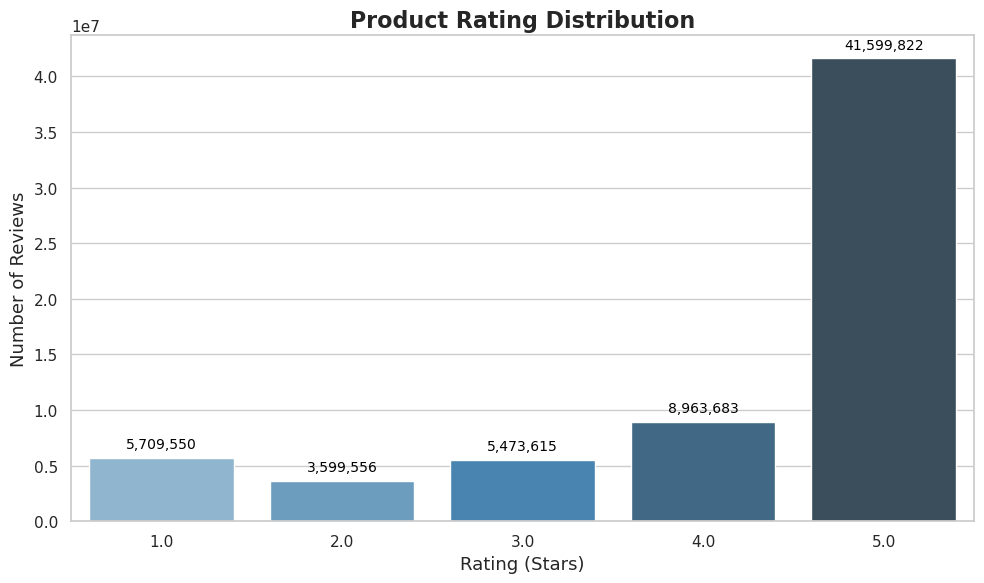

In [ ]:
rating_counts = clean_df.groupBy("rating").count().orderBy("rating")
rating_pd = rating_counts.toPandas()

sns.set(style="whitegrid", context="notebook")

plt.figure(figsize=(10, 6))

# Draw the barplot
ax = sns.barplot(data=rating_pd, x="rating", y="count", palette="Blues_d")

# Adding value labels on top of bars
for p in ax.patches:
    height = p.get_height()
    ax.annotate(f'{int(height):,}',
                (p.get_x() + p.get_width() / 2., height),
                ha='center', va='bottom',
                fontsize=10, color='black', xytext=(0, 5),
                textcoords='offset points')

plt.title("Product Rating Distribution", fontsize=16, fontweight='bold')
plt.xlabel("Rating (Stars)", fontsize=13)
plt.ylabel("Number of Reviews", fontsize=13)

# Customizing ticks
plt.xticks(fontsize=11)
plt.yticks(fontsize=11)

# Adding gridlines to Y-axis
ax.yaxis.grid(True)
ax.set_axisbelow(True)

plt.tight_layout()
plt.show()


#### Insights from the chart above:

- 5-star reviews dominate, indicating overwhelmingly positive customer feedback.

- Low counts of 1- and 2-star reviews suggest a strong positivity bias.

- Review counts increase steadily with rating, peaking sharply at 5 stars.

- The distribution is heavily right-skewed, showing disproportionate favor toward high ratings.

- Such skewed data may mask true product quality, warranting deeper sentiment analysis.

#### 1.3 Number of Reviews Over Time (by Year)

In [ ]:
reviews_by_year = clean_df.withColumn("year", year(from_unixtime(col("timestamp")/1000))) \
                           .groupBy("year") \
                           .count() \
                           .orderBy("year")

In [ ]:
reviews_by_year.cache()

DataFrame[year: int, count: bigint]

In [ ]:
reviews_by_year_pd = reviews_by_year.toPandas()

In [ ]:
reviews_by_year_pd["yoy_change"] = reviews_by_year_pd["count"].pct_change() * 100

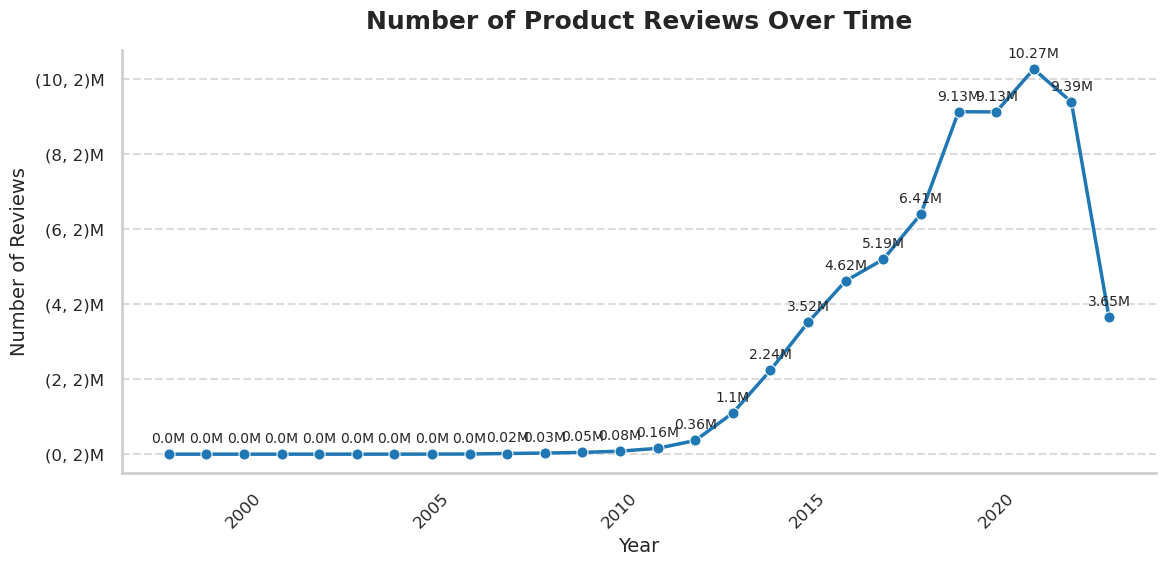

In [ ]:
sns.set(style="whitegrid", context="talk")

# Define figure size
plt.figure(figsize=(12, 6))

ax = sns.lineplot(
    data=reviews_by_year_pd,
    x="year",
    y="count",
    marker="o",
    linewidth=2.5,
    markersize=8,
    color="#1f77b4"
)

formatter = FuncFormatter(lambda x, _: f'{round(x/1000000),2}M')
ax.yaxis.set_major_formatter(formatter)

for x, y in zip(reviews_by_year_pd["year"], reviews_by_year_pd["count"]):
    ax.annotate(f'{round((y/1000000),2)}M', xy=(x, y), textcoords="offset points", xytext=(0, 8),
                ha='center', fontsize=10)

# Title and axis labels
plt.title("Number of Product Reviews Over Time", fontsize=18, fontweight="bold", pad=15)
plt.xlabel("Year", fontsize=14)
plt.ylabel("Number of Reviews", fontsize=14)

plt.xticks(rotation=45, fontsize=12)
plt.yticks(fontsize=12)

ax.yaxis.grid(True, linestyle='--', alpha=0.7)
ax.xaxis.grid(False)
ax.set_axisbelow(True)
sns.despine()
plt.tight_layout()

plt.show()


#### Insights from the chart above:

- Product reviews grew slowly until 2011, after which they began rising sharply.

- 2011–2020 saw rapid growth, peaking at 10.27 million reviews in 2020.

- Post-2020, review counts declined, suggesting saturation or behavioral shifts.

- 2023 review volume dropped significantly, falling to just 3.65 million (needs to be investigated, might be limited number of days of 2023 taken into consideration).

- This trend reflects a boom during the pandemic years, followed by a slight cooldown.

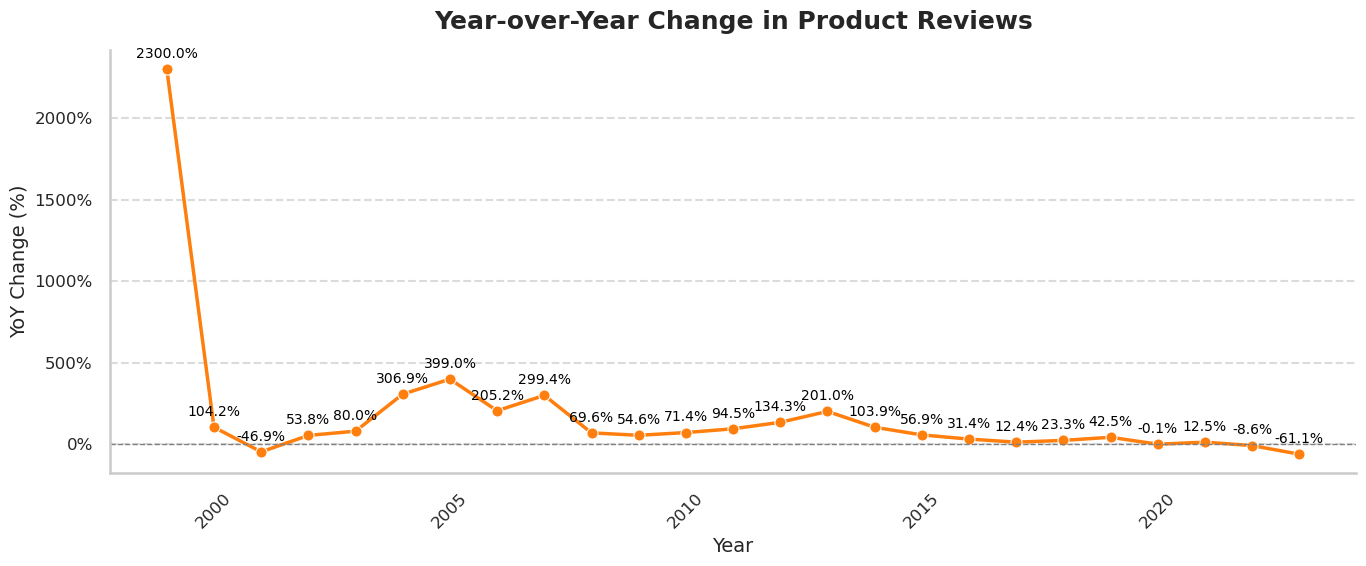

In [ ]:
sns.set(style="whitegrid", context="talk")

plt.figure(figsize=(14, 6))
ax = sns.lineplot(
    data=reviews_by_year_pd,
    x="year",
    y="yoy_change",
    marker="o",
    linewidth=2.5,
    markersize=8,
    color="#ff7f0e"
)

# Formatting y-axis as percentages
formatter = FuncFormatter(lambda x, _: f'{x:.0f}%')
ax.yaxis.set_major_formatter(formatter)

# Annotating each point with YoY %
for x, y in zip(reviews_by_year_pd["year"], reviews_by_year_pd["yoy_change"]):
    if pd.notnull(y):
        ax.annotate(f'{y:.1f}%', xy=(x, y), textcoords="offset points", xytext=(0, 8),
                    ha='center', fontsize=10, color="black")

plt.title("Year-over-Year Change in Product Reviews", fontsize=18, fontweight="bold", pad=15)
plt.xlabel("Year", fontsize=14)
plt.ylabel("YoY Change (%)", fontsize=14)

plt.xticks(rotation=45, fontsize=12)
plt.yticks(fontsize=12)

ax.axhline(0, linestyle="--", color="gray", linewidth=1)
ax.yaxis.grid(True, linestyle='--', alpha=0.7)
ax.xaxis.grid(False)
ax.set_axisbelow(True)
sns.despine()
plt.tight_layout()
plt.show()


#### Insights:

- Early 2000s had volatile YoY spikes, typical of platforms gaining traction.

- The highest YoY growth was in 2000 at 2300%, from a very low base.

- From 2010–2017, growth remained positive and steady, indicating healthy adoption.

- YoY growth dipped below 0% after 2020, signaling a slowdown.

- The sharp -61.1% decline in 2023 marks the steepest drop in review activity (needs to be investigated, might be limited number of days of 2023 taken into consideration).



#### 1.4 Verified vs Unverified Reviews by Rating

In [ ]:
verified_dist = clean_df.groupBy("verified_purchase", "rating").count().orderBy("rating", "verified_purchase")
verified_pd = verified_dist.toPandas()
verified_pd["verified_purchase"] = verified_pd["verified_purchase"].map({True: "Yes", False: "No"})

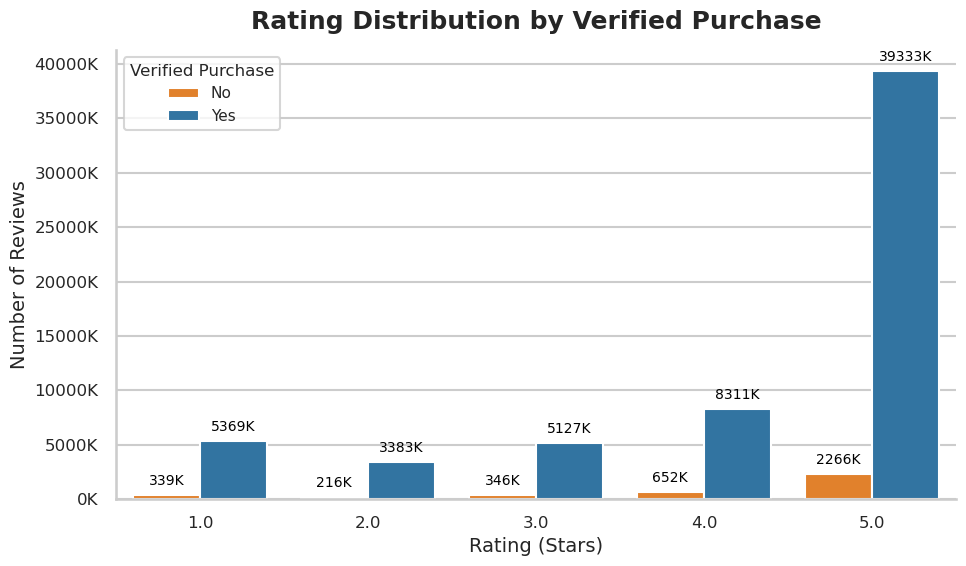

In [ ]:
sns.set(style="whitegrid", context="talk")

# Create figure
plt.figure(figsize=(10, 6))

# Defining color palette
palette = {"Yes": "#1f77b4", "No": "#ff7f0e"}

ax = sns.barplot(
    data=verified_pd,
    x="rating",
    y="count",
    hue="verified_purchase",
    palette=palette
)

ax.yaxis.set_major_formatter(FuncFormatter(lambda x, _: f'{int(x/1000)}K'))

# Annotate each bar
for p in ax.patches:
    height = p.get_height()
    if height > 0:
        ax.annotate(f'{int(height/1000)}K',
                    (p.get_x() + p.get_width() / 2., height),
                    ha='center', va='bottom',
                    fontsize=10, color='black',
                    xytext=(0, 5), textcoords='offset points')

# Titles and labels
plt.title("Rating Distribution by Verified Purchase", fontsize=18, fontweight='bold', pad=15)
plt.xlabel("Rating (Stars)", fontsize=14)
plt.ylabel("Number of Reviews", fontsize=14)

# Ticks and layout
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.legend(title="Verified Purchase", title_fontsize=12, fontsize=11)
plt.tight_layout()
sns.despine()

# Show plot
plt.show()


#### Insights from the chart above:

- Verified purchases account for the vast majority of reviews across all rating levels.

- 5-star reviews from verified buyers dominate, with 39.33M reviews.

- Unverified reviews are fewest for low ratings, and more frequent only at the 5-star level (2.27M).

- Ratings from verified purchases show a strong positive skew, peaking at 5 stars.

- The sharp contrast between verified and unverified reviews suggests potential authenticity concerns for unverified 5-star ratings.

#### 1.5 Top 10 Categories by Number of Reviews

In [ ]:
top_categories = clean_df.groupBy("main_category").count().orderBy(desc("count")).limit(10)
top_cat_pd = top_categories.toPandas()

/tmp/ipykernel_149232/267697495.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(


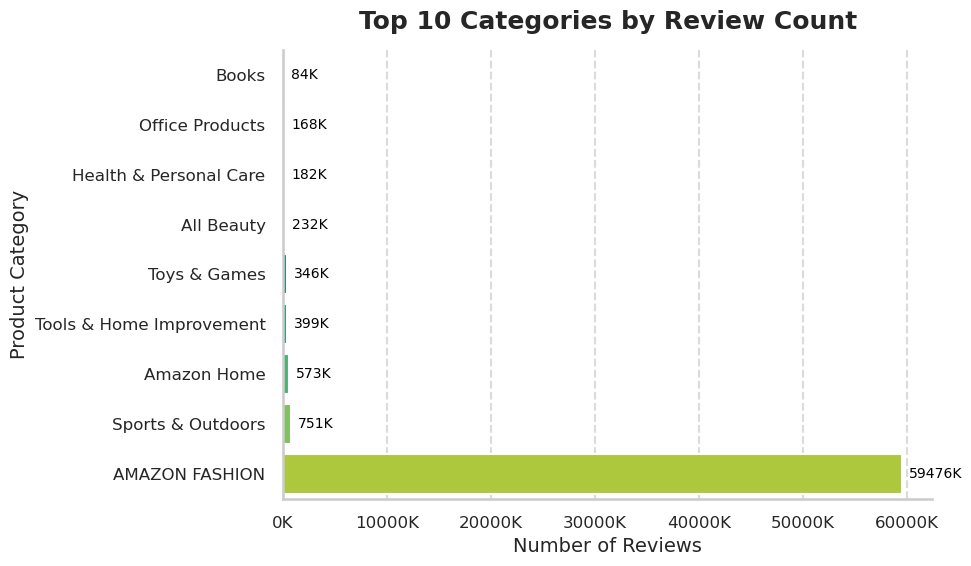

In [ ]:
sns.set(style="whitegrid", context="talk")
top_cat_pd = top_cat_pd.sort_values(by="count", ascending=True)  # for horizontal bars

plt.figure(figsize=(10, 6))

ax = sns.barplot(
    data=top_cat_pd,
    y="main_category",
    x="count",
    palette="viridis"
)

ax.xaxis.set_major_formatter(FuncFormatter(lambda x, _: f"{int(x / 1000)}K"))

for p in ax.patches:
    width = p.get_width()
    if width > 0:
        ax.annotate(f'{int(width/1000)}K',
                    (width, p.get_y() + p.get_height() / 2),
                    ha='left', va='center',
                    fontsize=10, color='black',
                    xytext=(5, 0), textcoords='offset points')

# Titles and labels
plt.title("Top 10 Categories by Review Count", fontsize=18, fontweight="bold", pad=15)
plt.xlabel("Number of Reviews", fontsize=14)
plt.ylabel("Product Category", fontsize=14)

plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
ax.xaxis.grid(True, linestyle='--', alpha=0.7)
ax.yaxis.grid(False)
sns.despine()

plt.tight_layout()

plt.show()

#### Insights from the chart above:

- Amazon Fashion dominates with 59.48 million reviews, vastly outpacing all other categories.

- The next highest, Sports & Outdoors, has just 751K reviews, highlighting an extreme imbalance.

- Categories like Books, Office Products, and Beauty have relatively low engagement despite being common retail segments (expected behaviour given the dataset belongs to Shoes, Clothes and Jewellery).



In [ ]:
length_df = clean_df.withColumn("text_length", length("text")).select("text_length")
length_pd = length_df.sample(False, 0.1).toPandas()  # Sample to make plot faster

In [ ]:
length_pd["text_length"].describe(percentiles=[.25, .5, .75, .9, .95])

count    6.535520e+06
mean     1.472052e+02
std      1.930088e+02
min      0.000000e+00
25%      3.900000e+01
50%      9.100000e+01
75%      1.840000e+02
90%      3.300000e+02
95%      4.640000e+02
max      2.975700e+04
Name: text_length, dtype: float64

#### 1.6 Boxplot for review length

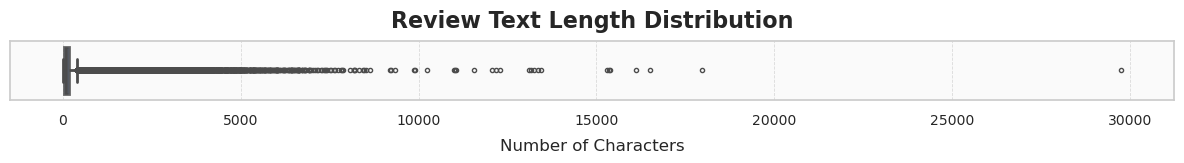

In [ ]:
sns.set_theme(style="whitegrid", context="notebook")

# Creating figure
plt.figure(figsize=(12, 1.8))
ax = sns.boxplot(
    x=length_pd["text_length"],
    color="#4c72b0",
    linewidth=2,
    fliersize=3,
    boxprops=dict(alpha=0.85)
)

plt.title("Review Text Length Distribution", fontsize=16, fontweight="bold", pad=10)
plt.xlabel("Number of Characters", fontsize=12, labelpad=8)

plt.xticks(fontsize=10)
plt.yticks([])

ax.set_facecolor("#fafafa")

plt.grid(axis='x', linestyle='--', linewidth=0.6, alpha=0.7)

plt.tight_layout()
plt.show()

#### 1.7 Histogram for length with Cut-Offs

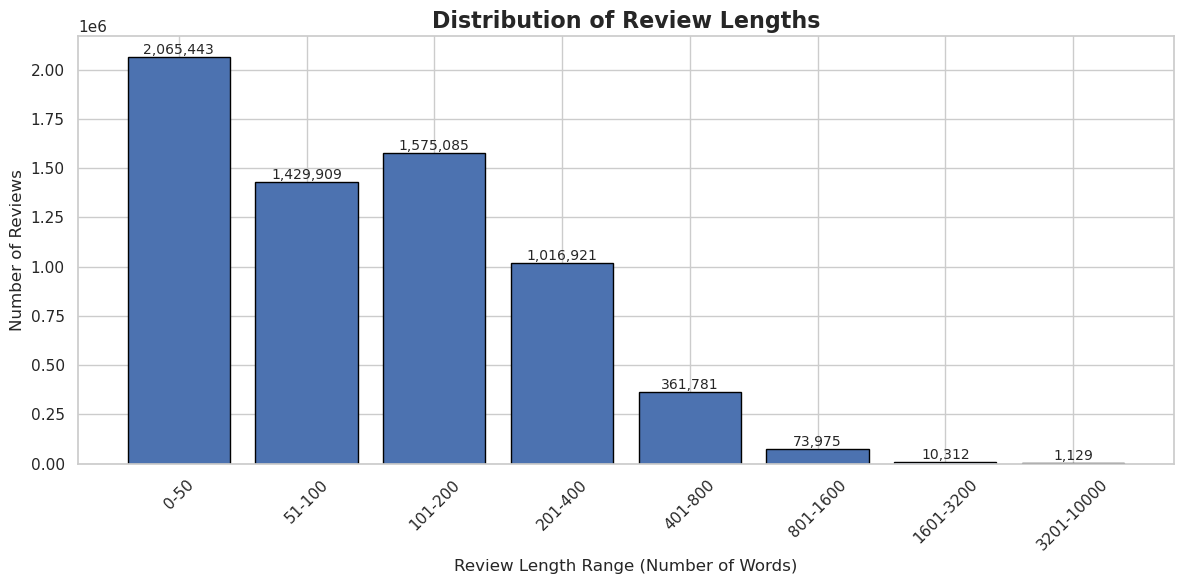

In [ ]:
sns.set(style="whitegrid")

# Defining custom labels for the bins
bin_labels = ['0-50', '51-100', '101-200', '201-400', '401-800', '801-1600', '1601-3200', '3201-10000']

# Cutting and labeling the bins
bins = [0, 50, 100, 200, 400, 800, 1600, 3200, 10000]
length_pd["length_bin"] = pd.cut(length_pd["text_length"], bins=bins, labels=bin_labels)

# Counting values
length_bin_counts = length_pd["length_bin"].value_counts().sort_index()


plt.figure(figsize=(12, 6))
bars = plt.bar(length_bin_counts.index, length_bin_counts.values, color=sns.color_palette("deep")[0], edgecolor='black')

# Adding value labels on top of each bar
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, height + 100, f'{height:,}',
             ha='center', va='bottom', fontsize=10)

# Titles and labels
plt.title("Distribution of Review Lengths", fontsize=16, fontweight='bold')
plt.xlabel("Review Length Range (Number of Words)", fontsize=12)
plt.ylabel("Number of Reviews", fontsize=12)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


#### Insights from the chart above:

- Short reviews (0–50 words) dominate, with over 2 million entries, making them the most common.

- Review frequency steadily decreases as length increases, showing a preference for concise feedback.

- Very long reviews (800+ words) are extremely rare, making up only a tiny fraction of total reviews.

#### 1.8 Average Review length by Rating

In [ ]:
length_rating_df_grouped = clean_df.withColumn("text_length", length("text")) \
                           .select("text_length", "rating") \
                           .sample(False, 0.1) \
                           .toPandas()

# Group by rating and calculate mean text length
avg_length_by_rating = length_rating_df_grouped.groupby("rating")["text_length"].mean().sort_index()

In [ ]:
length_rating_df = clean_df.withColumn("text_length", length("text")) \
                           .select("text_length", "rating") \
                           .sample(False, 0.1) \
                           .toPandas()

/tmp/ipykernel_149232/1425036606.py:23: FutureWarning:                          

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  barplot = sns.barplot(


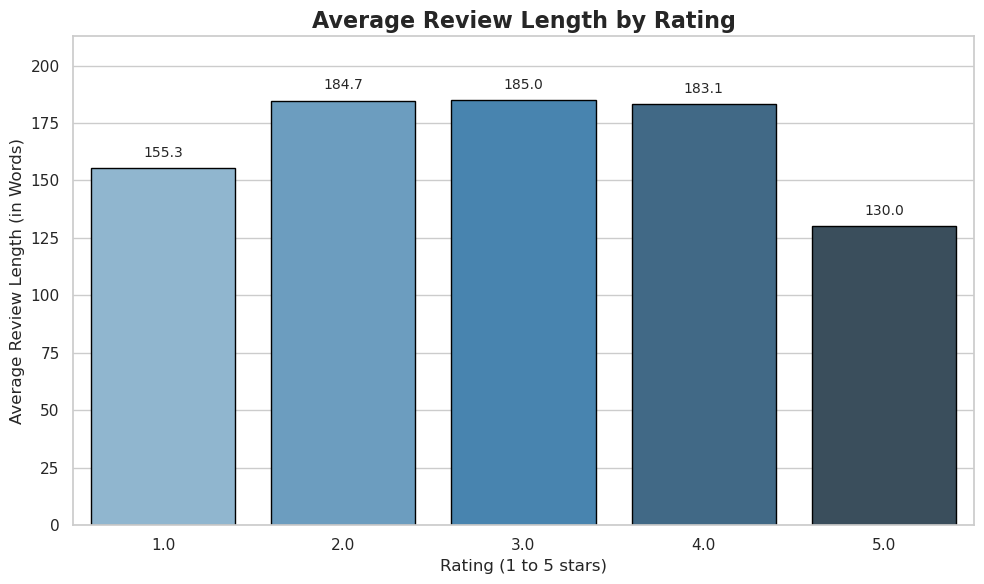

In [ ]:
# Compute average review length per rating
length_rating_df = clean_df.withColumn("text_length", length("text")) \
                           .select("text_length", "rating") \
                           .sample(False, 0.1) \
                           .toPandas()

avg_length_by_rating = (
    length_rating_df.groupby("rating")["text_length"]
    .mean()
    .sort_index()
    .reset_index()
)

# Set style
sns.set(style="whitegrid", context="notebook")

# Create the figure
plt.figure(figsize=(10, 6))
barplot = sns.barplot(
    data=avg_length_by_rating,
    x="rating",
    y="text_length",
    palette="Blues_d",
    edgecolor="black"
)

# Add value labels above bars
for index, row in avg_length_by_rating.iterrows():
    plt.text(
        x=index,
        y=row["text_length"] + 5,
        s=f'{row["text_length"]:.1f}',
        ha='center',
        fontsize=10,
        fontweight='medium'
    )

# Titles and labels
plt.title("Average Review Length by Rating", fontsize=16, fontweight='bold')
plt.xlabel("Rating (1 to 5 stars)", fontsize=12)
plt.ylabel("Average Review Length (in Words)", fontsize=12)

# Optional: shrink y-axis if values are too high
plt.ylim(0, avg_length_by_rating["text_length"].max() * 1.15)

# Final layout adjustments
plt.tight_layout()
plt.show()


#### Insights from the chart above:

- 3-star reviews are the longest on average, at 185 words, suggesting more nuanced feedback.

- 5-star reviews are the shortest, averaging just 130 words, likely due to quick positive comments.

- Mid-range ratings (2–4 stars) tend to have longer reviews, possibly reflecting more detailed opinions or mixed experiences.

/tmp/ipykernel_149232/2414323652.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  box = sns.boxplot(


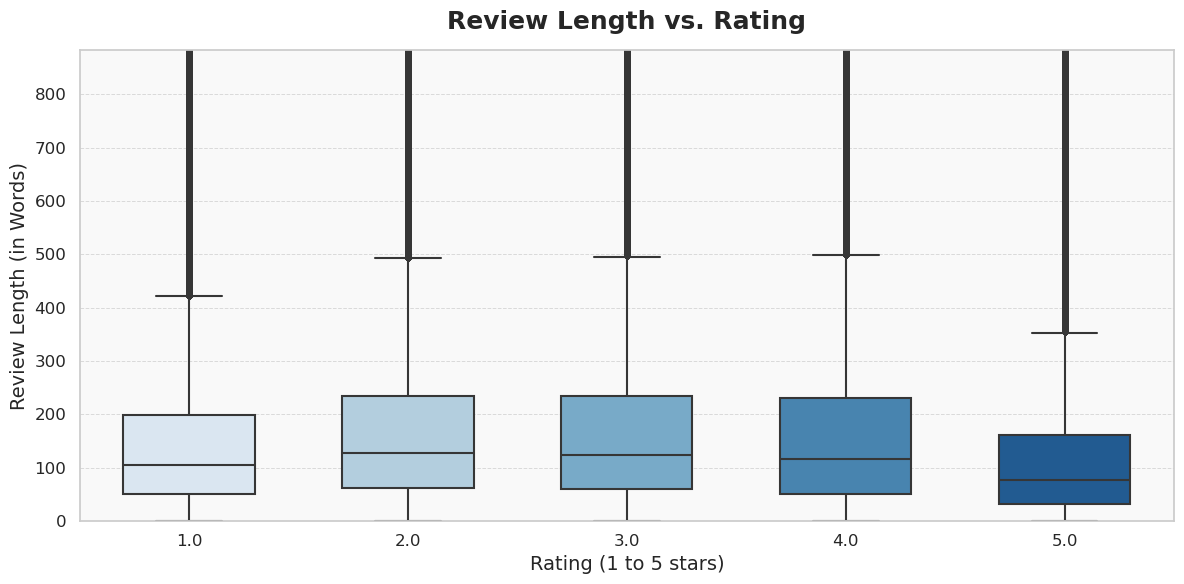

In [ ]:
#Diving deeper into the distribution of length vs Ratings

sns.set(style="whitegrid", context="notebook")

plt.figure(figsize=(12, 6))
box = sns.boxplot(
    data=length_rating_df,
    x="rating",
    y="text_length",
    palette="Blues",
    linewidth=1.5,
    fliersize=3,  # small dots for outliers
    width=0.6
)

# Titles and labels
plt.title("Review Length vs. Rating", fontsize=18, fontweight='bold', pad=15)
plt.xlabel("Rating (1 to 5 stars)", fontsize=14)
plt.ylabel("Review Length (in Words)", fontsize=14)

# Adjusting ticks and grid
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.grid(axis='y', linestyle='--', linewidth=0.7, alpha=0.7)

# Trimming extreme outliers to focus on central distribution
plt.ylim(0, length_rating_df["text_length"].quantile(0.99))

box.set_facecolor("#f9f9f9")

plt.tight_layout()
plt.show()

#### Insights from the chart above:

- 3-star and 4-star reviews have the longest median lengths, indicating more detailed, balanced feedback.

- 5-star reviews have the shortest median length and narrowest spread, suggesting quick, positive sentiments.

- 1-star reviews show high variability, with some users writing very long complaints.

- All rating groups contain significant outliers, especially in the upper range, reflecting a few extremely lengthy reviews.

#### 1.9 Generating word cloud based on the ratings.

In [ ]:
# -------------------------------------------------------------------------------------------------------------
# NOTE: The spark session was crashing because of the high volume of data, hence limited it to 100,000 records.
# -------------------------------------------------------------------------------------------------------------

limited_df = clean_df.select("rating", "text").limit(100000)
reviews_pd = limited_df.toPandas()

reviews_pd["cleaned_text"] = reviews_pd["text"].apply(preprocess)

# Group cleaned reviews by rating
grouped = reviews_pd.groupby("rating")["cleaned_text"].apply(lambda texts: " ".join(texts)).reset_index()

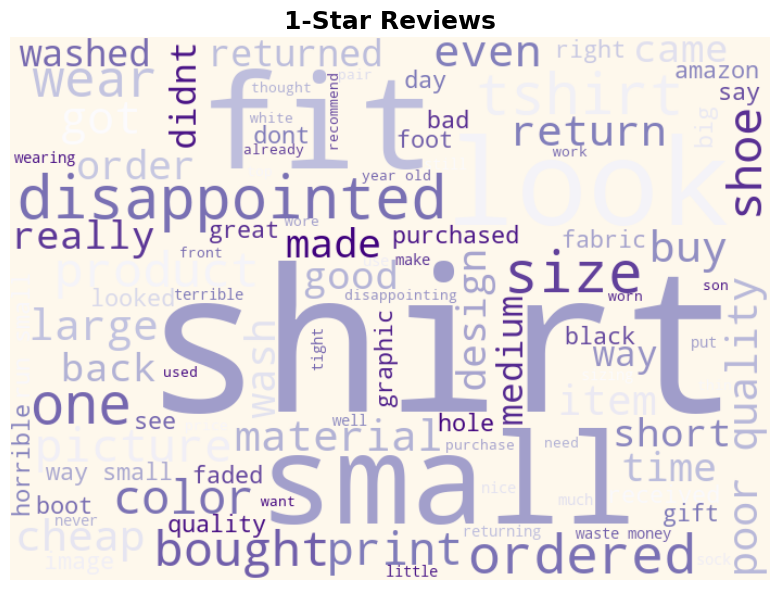

In [ ]:
# Word cloud for rating 1 reviews

text_1 = grouped[grouped["rating"] == 1]["cleaned_text"].values

if len(text_1) > 0:
    short_text_1 = " ".join(text_1[0].split()[:])

    wc1 = WordCloud(
        width=700, height=500,
        background_color="#fef8ec",
        colormap="Purples",
        max_words=100,
        contour_color='black',
        contour_width=1,
        prefer_horizontal=0.9
    ).generate(short_text_1)

    plt.figure(figsize=(10, 6))
    plt.imshow(wc1, interpolation='bilinear')
    plt.axis("off")
    plt.title("1-Star Reviews", fontsize=18, fontweight='bold')
    plt.tight_layout()
    plt.show()

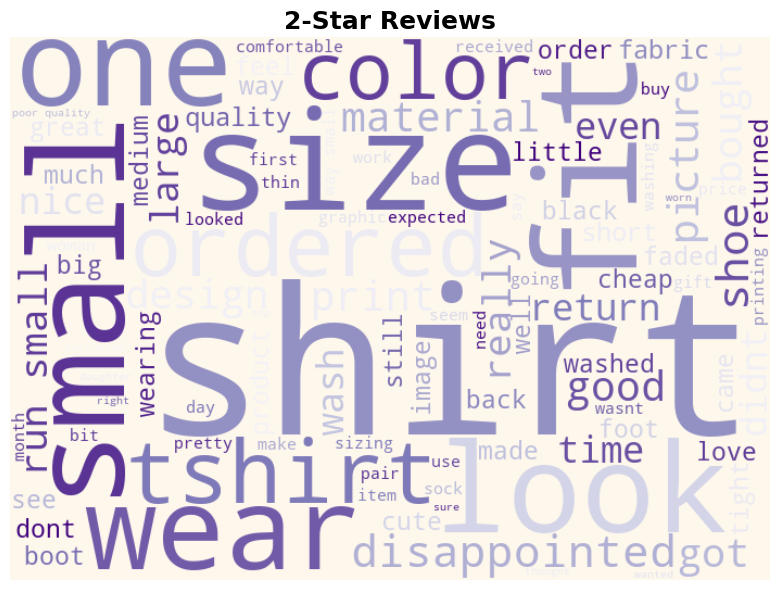

In [ ]:
# Word cloud for rating 2 reviews

text_2 = grouped[grouped["rating"] == 2]["cleaned_text"].values

if len(text_2) > 0:
    short_text_2 = " ".join(text_2[0].split()[:])

    wc1 = WordCloud(
        width=700, height=500,
        background_color="#fef8ec",
        colormap="Purples",
        max_words=100,
        contour_color='black',
        contour_width=1,
        prefer_horizontal=0.9
    ).generate(short_text_2)

    plt.figure(figsize=(10, 6))
    plt.imshow(wc1, interpolation='bilinear')
    plt.axis("off")
    plt.title("2-Star Reviews", fontsize=18, fontweight='bold')
    plt.tight_layout()
    plt.show()

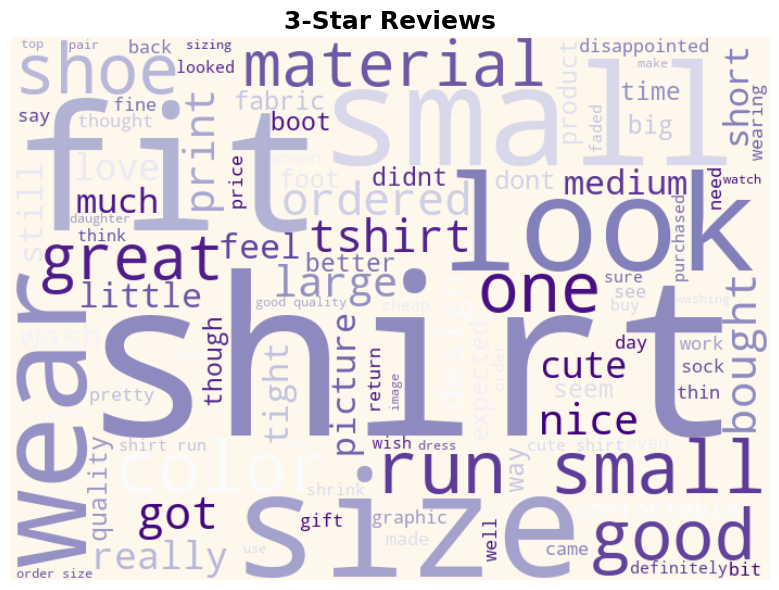

In [ ]:
# Word cloud for rating 3 reviews

text_3 = grouped[grouped["rating"] == 3]["cleaned_text"].values

if len(text_3) > 0:
    short_text_3 = " ".join(text_3[0].split()[:])

    wc1 = WordCloud(
        width=700, height=500,
        background_color="#fef8ec",
        colormap="Purples",
        max_words=100,
        contour_color='black',
        contour_width=1,
        prefer_horizontal=0.9
    ).generate(short_text_3)

    plt.figure(figsize=(10, 6))
    plt.imshow(wc1, interpolation='bilinear')
    plt.axis("off")
    plt.title("3-Star Reviews", fontsize=18, fontweight='bold')
    plt.tight_layout()
    plt.show()

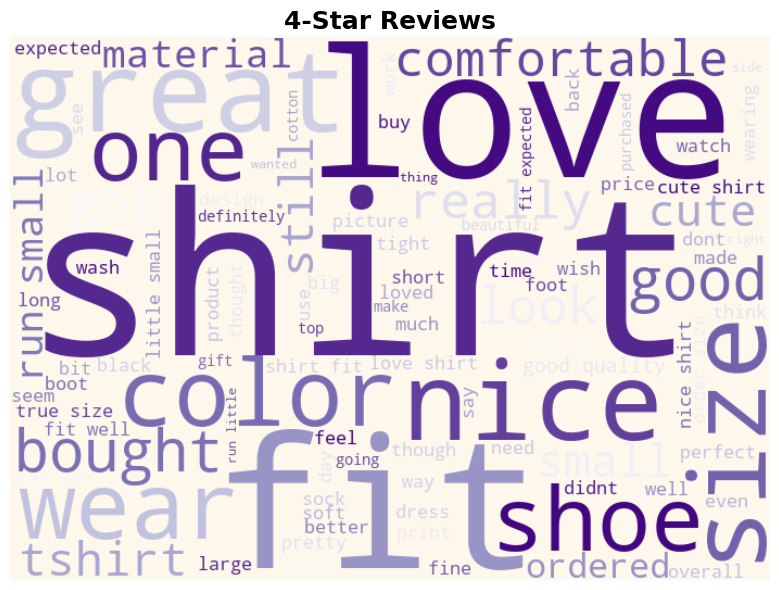

In [ ]:
# Word cloud for rating 4 reviews

text_4 = grouped[grouped["rating"] == 4]["cleaned_text"].values

if len(text_4) > 0:
    short_text_4 = " ".join(text_4[0].split()[:])

    wc1 = WordCloud(
        width=700, height=500,
        background_color="#fef8ec",
        colormap="Purples",
        max_words=100,
        contour_color='black',
        contour_width=1,
        prefer_horizontal=0.9
    ).generate(short_text_4)

    plt.figure(figsize=(10, 6))
    plt.imshow(wc1, interpolation='bilinear')
    plt.axis("off")
    plt.title("4-Star Reviews", fontsize=18, fontweight='bold')
    plt.tight_layout()
    plt.show()

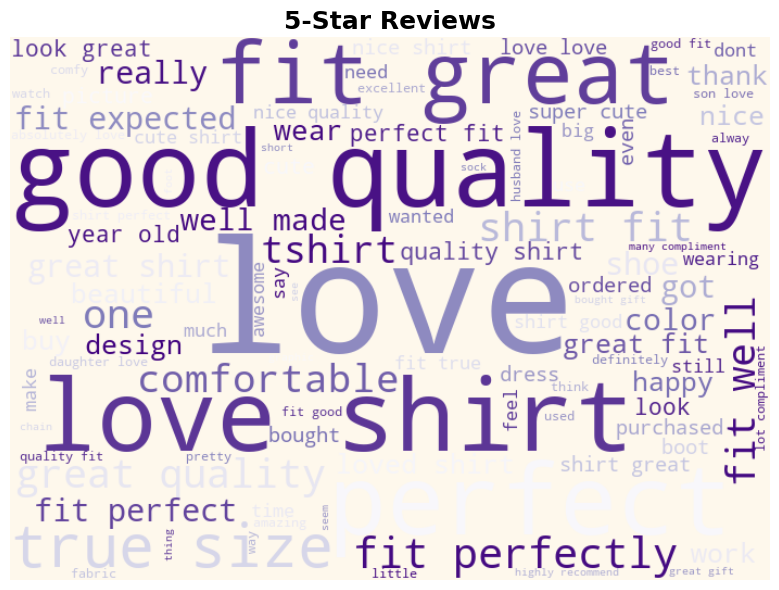

In [ ]:
# Word cloud for rating 5 reviews

text_5 = grouped[grouped["rating"] == 5]["cleaned_text"].values

if len(text_5) > 0:
    short_text_5 = " ".join(text_5[0].split()[:])

    wc1 = WordCloud(
        width=700, height=500,
        background_color="#fef8ec",
        colormap="Purples",
        max_words=100,
        contour_color='black',
        contour_width=1,
        prefer_horizontal=0.9
    ).generate(short_text_5)

    plt.figure(figsize=(10, 6))
    plt.imshow(wc1, interpolation='bilinear')
    plt.axis("off")
    plt.title("5-Star Reviews", fontsize=18, fontweight='bold')
    plt.tight_layout()
    plt.show()

#### Insights from the wordcloud charts above:

- "Shirt," "fit," and "size" appear across all ratings, highlighting clothing fit as the most discussed issue.

- Negative reviews (1–2 stars) emphasize words like “disappointed,” “returned,” “cheap,” “small,” “faded,” and “hole,” indicating dissatisfaction with quality, sizing, and returns.

- "Small" and "tight" are dominant in low ratings, suggesting that poor sizing is a key reason for negative feedback.

- Words like “ordered,” “didn’t,” “wrong,” and “returned” in 1- and 2-star reviews indicate issues with order accuracy and return experiences.

- Mid-tier (3-star) reviews show a mix of both positive and negative sentiment with words like “great,” “but,” “tight,” and “expected,” suggesting mixed or average experiences.

- In 4-star reviews, the tone shifts noticeably with words like “love,” “comfortable,” “cute,” “nice,” and “fit well,” implying mostly positive experiences with minor flaws.

- 5-star reviews are dominated by words like “love,” “perfect,” “great,” “quality,” and “fit perfectly,” signaling strong satisfaction and high product approval.

- The presence of "true to size" and “fit perfectly” in 5-star reviews reflects a positive sizing experience compared to “small” and “tight” in lower ratings.

- “Comfortable” and “good quality” emerge strongly from 4- and 5-star reviews, suggesting these are key drivers of high ratings.

- Positive adjectives increase with star rating (e.g., “disappointed” → “expected” → “great” → “perfect”), showing a clear sentiment progression from negative to highly satisfied customers.



------

In [ ]:
spark.stop()

# **Summary of Phase 1 Notebook & Next Steps**

At this point in the project we have successfully loaded our data into GCS and converted it from JSONL to Parquet for ease of use in Spark. From there, the team has conducted an in-depth exploratory data analysis of both of our datasets combined, to gain a better understanding of the landscape our data. Some of our key insights include:


**Key Findings from EDA Phase:**

- Reviews Distribution: The dataset focuses on Amazon’s "Clothing, Shoes & Jewelry" category, with a significant concentration of ratings around 4 and 5 stars.

- Product Popularity: Certain products have significantly more reviews, indicating bestsellers in the category.

- Brand Analysis: A few brands dominate the dataset, while many have a smaller presence.

- Pricing Trends: Products with higher ratings tend to have varying price ranges, but there isn't a clear-cut correlation.

- Review Trends Over Time: Reviews exhibit seasonal trends, with spikes likely due to holiday sales or promotions.


The insights from our exploratory data analysis (EDA) provide a strong foundation for the next steps in our analysis. By understanding the distribution of reviews, product popularity, and brand dominance, we can better contextualize topic modeling and aspect-based sentiment analysis to extract product-specific feedback. Additionally, patterns in review ratings and frequency will help detect suspicious reviews through anomaly detection techniques. The classification of review intent, informed by EDA trends, will enhance customer response strategies by identifying common concerns, praise, and inquiries.

Finally, leveraging these structured insights, we can try implementing a question-answering/review summarizer model to extract meaningful responses from the vast pool of customer reviews, ultimately improving decision-making for both sellers and consumers.


##  Future Work

In the next phase, we plan to implement the following machine learning analyses to generate business insights:

- **Sentiment Analysis**  
  Predict sentiment from review text to gauge customer satisfaction levels.

- **Topic Modeling**  
  Use unsupervised learning to discover common themes and issues discussed in reviews.

- **Review Helpfulness Prediction**  
  Build a model to predict which reviews are likely to be rated helpful by other customers.

- **Time Series Analysis**  
  Analyze trends in review activity and sentiment over time to uncover seasonal or temporal patterns.